# Introduction to Qiskit Runtime and Qiskit Primitives

Junye Huang

Quantum Developer Advocate

# Outline

- Qiskit Runtime
  - What is Qiskit Runtime?
  - Getting started with Qiskit Runtime
- Qiskit Primitives
  - What are Qiskit Primitives?
  - How to use Sampler primitive
  - How to use Estimator primitive

# What is Qiskit Runtime

Qiskit Runtime is a new programming model, bring quantum closer to classical to speed up hybrid workflow


## Why do we want  to use Qiskit Runtime?

Qiskit Runtime can speed up hybrid workflow

# Getting started with Qiskit Runtime

# Installation

```bash
pip install qiskit
pip install qiskit-ibm-runtime
```

# Find your access credentials

You can access Qiskit Runtime from either IBM Quantum or IBM Cloud.

## IBM Quantum

Retrieve IBM Quantum token here: https://quantum-computing.ibm.com/account

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")

## IBM Cloud

Retrieve IBM Cloud token here: https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-quickstart

In [ ]:
QiskitRuntimeService.save_account(channel="ibm_cloud", 
                                  token="MY_IBM_CLOUD_API_KEY", 
                                  instance="MY_IBM_CLOUD_CRN")

# Run "Hello World" program

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
program_inputs = {'iterations': 1}
options = {"backend_name": "ibmq_qasm_simulator"}
job = service.run(program_id="hello-world",
                  options=options,
                  inputs=program_inputs
                 )
print(f"job id: {job.job_id}")
result = job.result()
print(result)

job id: ca5lvql9epflseke5bl0
Hello, World!


# What are Qiskit Primitives

[Programming language primitives](https://en.wikipedia.org/wiki/Language_primitive) are the most basic block of processing available to a programmer.

Qiskit primitives include 4 primitives with 4 levels of output
1. Integrator: returns **raw voltages** of measurement signals
2. Discriminator: returns **individual shot** measurement outcome
3. Sampler: returns **(quasi-)probabilities** of measurement outcomes
4. Estimator: returns **expectation value** of an observable

Nested programs are composed of Qiskit primitives programs.

# Why do we change to Qiskit Primitives?

Short answer: error mitigation.

Long answer:
1. We are already using these 4 levels of output. They were added in gradually and therefore messy. 
    1. integrator: pulse measurement level 0 & 1
    2. discriminator: pulse measurement level 2 & `memory=True`
    3. sampler: `result.get_counts()` & `circuit_runner` program
    4. estimator: `opflow`
2. Unifying the interfaces can enhance the abstractions and enable different kinds of error mitigation techniques to improve results at different output levels.

# What is Sampler primitive

Sampler is probably most familar program to existing Qiskit users. It's very similar to existing `backend.run()` model. The main difference is that instead of returing raw `counts`, the result is presented as `(quasi-)probability`.

What does quasi-probability mean?
- Can be negative values
- Quantum mechanics allows for events with a negative expectation values, to acount for phenomena like destructive interference.

Reference: https://en.wikipedia.org/wiki/Quasiprobability_distribution

# How to use Sampler primitive

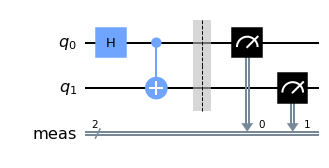

In [2]:
from qiskit import QuantumCircuit

bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()
bell.draw()

In [9]:
from qiskit_ibm_runtime import Sampler

with Sampler(circuits=bell, service=service, options={"backend": "ibmq_qasm_simulator"}) as sampler:
    result1 = sampler(circuit_indices=[0], shots=1000)
    print(result1)
    
    result2 = sampler(circuit_indices=[0], shots=2000)
    print(result2)

SamplerResult(quasi_dists=[{'00': 0.503, '11': 0.497}], metadata=[{'header_metadata': {}, 'shots': 1000}])
SamplerResult(quasi_dists=[{'11': 0.517, '00': 0.483}], metadata=[{'header_metadata': {}, 'shots': 2000}])


In [10]:
# You can see that the results are probabilities, not counts
results_primitives = [result1.quasi_dists[0], result2.quasi_dists[0]]
print(results_primitives)

[{'00': 0.503, '11': 0.497}, {'11': 0.517, '00': 0.483}]


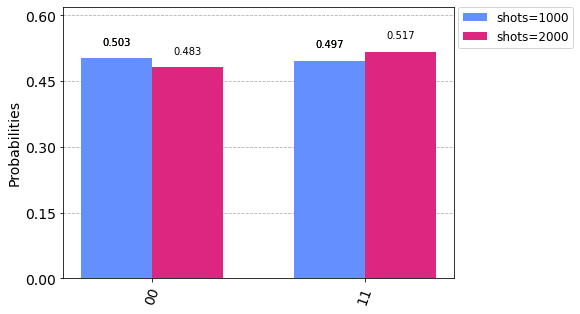

In [11]:
from qiskit.visualization import plot_histogram

plot_histogram(results_primitives, legend=['shots=1000', 'shots=2000'])

# The Old Way

In [12]:
from qiskit import IBMQ

provider = IBMQ.load_account()
simulator = provider.get_backend('ibmq_qasm_simulator')

job1 = simulator.run(bell, shots=1000)
job2 = simulator.run(bell, shots=2000)

In [13]:
# You can see that the results are counts, not probabilities
results_backend_run = [job1.result().get_counts(), job2.result().get_counts()]
print(results_backend_run)

[{'00': 501, '11': 499}, {'00': 1005, '11': 995}]


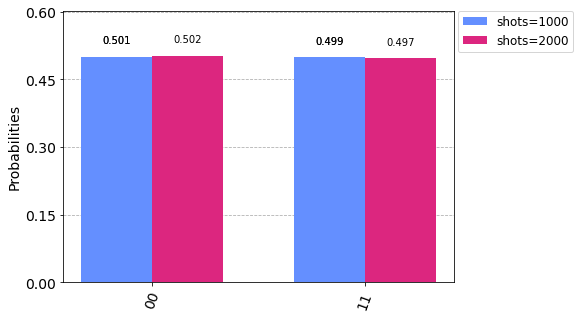

In [14]:
plot_histogram(results_backend_run, legend=['shots=1000', 'shots=2000'])

# Running mutiple circuits

In [16]:
with Sampler(circuits=[bell]*3, service=service, options={"backend": "ibmq_qasm_simulator"}) as sampler:
    result = sampler(circuit_indices=[0, 1, 2])
    print(result)

SamplerResult(quasi_dists=[{'11': 0.4935, '00': 0.5065}, {'11': 0.4855, '00': 0.5145}, {'00': 0.5085, '11': 0.4915}], metadata=[{'header_metadata': {}, 'shots': 2000}, {'header_metadata': {}, 'shots': 2000}, {'header_metadata': {}, 'shots': 2000}])


# Running parameterized circuits

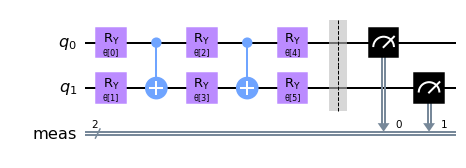

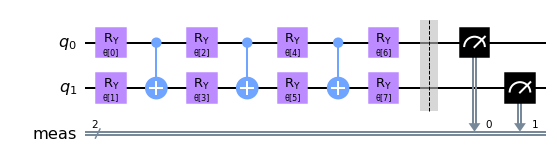

In [5]:
from qiskit.circuit.library import RealAmplitudes
from IPython.display import display

# parameterized circuit
pqc = RealAmplitudes(num_qubits=2, reps=2)
pqc.measure_all()
pqc2 = RealAmplitudes(num_qubits=2, reps=3)
pqc2.measure_all()

display(pqc.decompose().draw())
display(pqc2.decompose().draw())

In [6]:
theta1 = [0, 1, 1, 2, 3, 5]
theta2 = [1, 2, 3, 4, 5, 6]
theta3 = [0, 1, 2, 3, 4, 5, 6, 7]

with Sampler(circuits=[pqc, pqc2], service=service, options={"backend": "ibmq_qasm_simulator"}) as sampler:
    result = sampler(circuit_indices=[0, 0, 1], parameter_values=[theta1, theta2, theta3])
    print(result)

SamplerResult(quasi_dists=[{'00': 0.1416015625, '10': 0.109375, '01': 0.3603515625, '11': 0.388671875}, {'01': 0.029296875, '00': 0.0673828125, '10': 0.611328125, '11': 0.2919921875}, {'11': 0.0263671875, '10': 0.0869140625, '00': 0.171875, '01': 0.71484375}], metadata=[{'header_metadata': {}, 'shots': 1024}, {'header_metadata': {}, 'shots': 1024}, {'header_metadata': {}, 'shots': 1024}])


# How to use Estimator primitive

Estimator estimates the expecation value of an observable. 

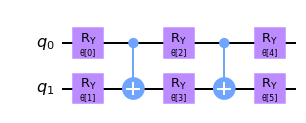

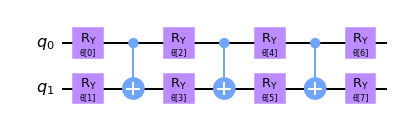

In [7]:
from qiskit.quantum_info import SparsePauliOp

psi1 = RealAmplitudes(num_qubits=2, reps=2)
psi2 = RealAmplitudes(num_qubits=2, reps=3)

H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
H2 = SparsePauliOp.from_list([("IZ", 1)])
H3 = SparsePauliOp.from_list([("ZI", 1), ("ZZ", 1)])

display(psi1.decompose().draw())
display(psi2.decompose().draw())

In [8]:
from qiskit_ibm_runtime import Estimator

with Estimator(circuits=[psi1, psi2], observables=[H1, H2, H3], service=service, 
               options={"backend": "ibmq_qasm_simulator"}
) as estimator:
    theta1 = [0, 1, 1, 2, 3, 5]
    theta2 = [0, 1, 1, 2, 3, 5, 8, 13]
    theta3 = [1, 2, 3, 4, 5, 6]

    # calculate [ <psi1(theta1)|H1|psi1(theta1)> ]
    psi1_H1_result = estimator(circuit_indices=[0], observable_indices=[0], parameter_values=[theta1])
    print(psi1_H1_result)

    # calculate [ <psi1(theta1)|H2|psi1(theta1)>, <psi1(theta1)|H3|psi1(theta1)> ]
    psi1_H23_result = estimator(circuit_indices=[0, 0], observable_indices=[1, 2], parameter_values=[theta1]*2)
    print(psi1_H23_result)

    # calculate [ <psi2(theta2)|H2|psi2(theta2)> ]
    psi2_H2_result = estimator([1], [1], [theta2])
    print(psi2_H2_result)

    # calculate [ <psi1(theta1)|H1|psi1(theta1)>, <psi1(theta3)|H1|psi1(theta3)> ]
    psi1_H1_result2 = estimator([0, 0], [0, 0], [theta1, theta3])
    print(psi1_H1_result2)

    # calculate [ <psi1(theta1)|H1|psi1(theta1)>, <psi2(theta2)|H2|psi2(theta2)>, <psi1(theta3)|H3|psi1(theta3)> ]
    psi12_H123_result = estimator([0, 1, 0], [0, 1, 2], [theta1, theta2, theta3])
    print(psi12_H123_result)

EstimatorResult(values=array([1.55664062]), metadata=[{'variance': 8.971965789794922, 'shots': 1024}])
EstimatorResult(values=array([-0.4921875 ,  0.09570312]), metadata=[{'variance': 0.75775146484375, 'shots': 1024}, {'variance': 1.9951896667480469, 'shots': 1024}])
EstimatorResult(values=array([0.18554688]), metadata=[{'variance': 0.9655723571777344, 'shots': 1024}])
EstimatorResult(values=array([1.53320312, 1.05859375]), metadata=[{'variance': 9.304027557373047, 'shots': 1024}, {'variance': 12.152267456054688, 'shots': 1024}])
EstimatorResult(values=array([ 1.53515625,  0.23828125, -1.09765625]), metadata=[{'variance': 9.339340209960938, 'shots': 1024}, {'variance': 0.9432220458984375, 'shots': 1024}, {'variance': 1.2371673583984375, 'shots': 1024}])


In [18]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.4.0'

In [17]:
import qiskit.tools.jupyter

%qiskit_version_table